## Basic Setup

In [4]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.quiet(quietval=True)
seed = 24
np.random.seed(seed)

resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ez,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,resolution=design_region_resolution)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Ez0 = mpa.Ez_Coefficients(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(2,0,0)))
ob_list = [Ez0]



def J1(alpha):
    return npa.abs(alpha[0,0]) **2


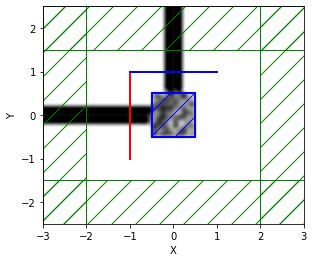

In [5]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)


Nx = design_variables.Nx # number of parameters in the x direction
Ny = design_variables.Ny # number of parameters in the y direction
x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])


opt.plot2D(True)
plt.show()



Starting forward run...
Starting adjoint run...
(-3.545175204830475e-05+7.865328006618184e-05j)
Calculating gradient...


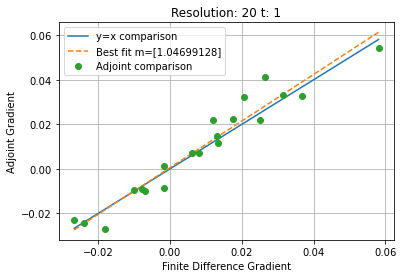

Starting forward run...
Starting adjoint run...
(-3.5453350492890815e-05+7.865435713506238e-05j)
Calculating gradient...


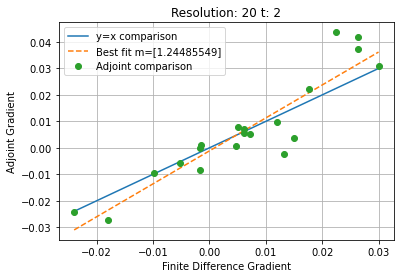

Starting forward run...
Starting adjoint run...
(-3.545549885894896e-05+7.865474501092911e-05j)
Calculating gradient...


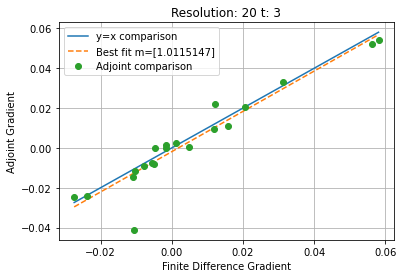

Starting forward run...
Starting adjoint run...
(-3.545622312454649e-05+7.865548592038269e-05j)
Calculating gradient...


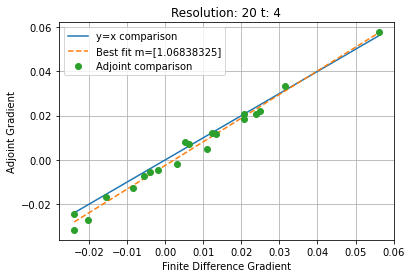

Starting forward run...
Starting adjoint run...
(-3.545809980196688e-05+7.865594396924921e-05j)
Calculating gradient...


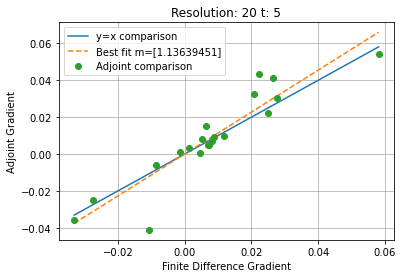

Starting forward run...
Starting adjoint run...
(-1.2275094568494352e-05+2.6914698642009804e-05j)
Calculating gradient...


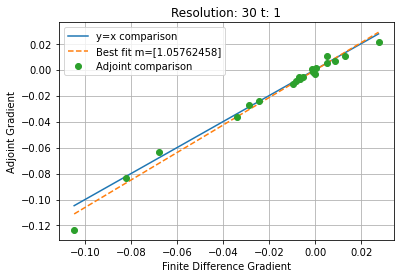

Starting forward run...
Starting adjoint run...
(-1.2275462814424331e-05+2.6912597247249174e-05j)
Calculating gradient...


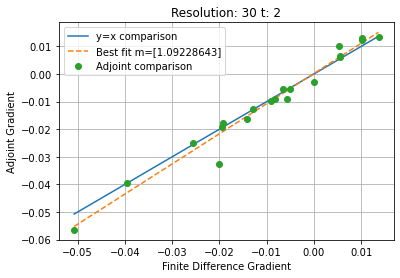

Starting forward run...
Starting adjoint run...
(-1.2275513451062456e-05+2.691145211288807e-05j)
Calculating gradient...


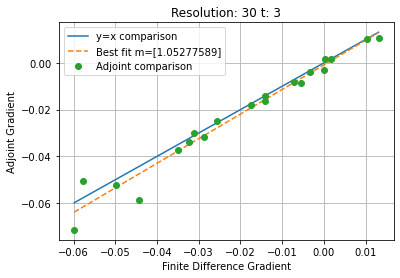

Starting forward run...
Starting adjoint run...
(-1.2275594390858083e-05+2.6908998714582968e-05j)
Calculating gradient...


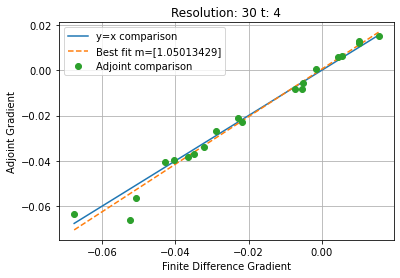

Starting forward run...
Starting adjoint run...
(-1.2275433230265969e-05+2.6906627898450752e-05j)
Calculating gradient...


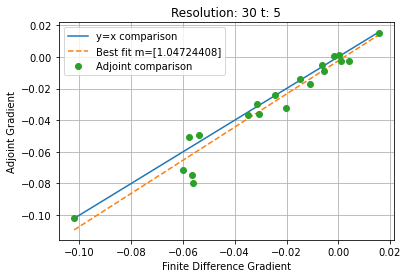

Starting forward run...
Starting adjoint run...
(-8.38221545027536e-06+1.7891229337383416e-05j)
Calculating gradient...


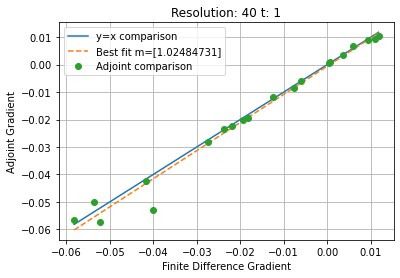

Starting forward run...
Starting adjoint run...
(-8.382153004926854e-06+1.789028316135879e-05j)
Calculating gradient...


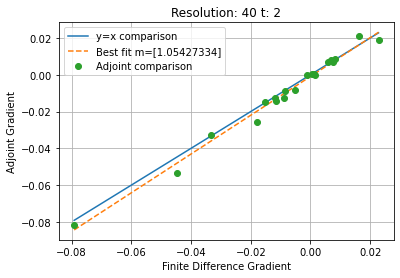

Starting forward run...
Starting adjoint run...
(-8.382592550785774e-06+1.788959876180006e-05j)
Calculating gradient...


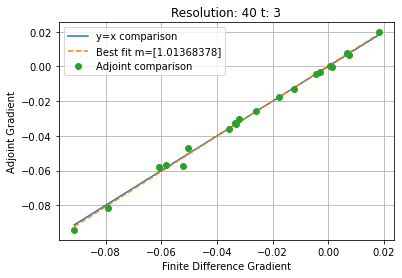

Starting forward run...
Starting adjoint run...
(-8.382272523831349e-06+1.7888154551022617e-05j)
Calculating gradient...


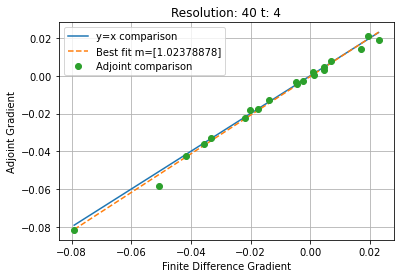

Starting forward run...
Starting adjoint run...
(-8.382535432838314e-06+1.7887319925684692e-05j)
Calculating gradient...


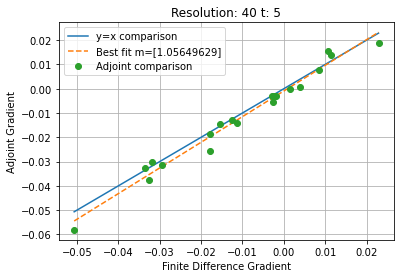

Starting forward run...
Starting adjoint run...
(-4.49045256050797e-06+1.031314000865575e-05j)
Calculating gradient...


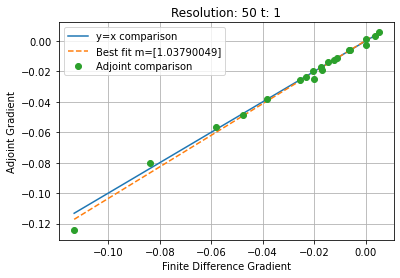

Starting forward run...
Starting adjoint run...
(-4.490244357912203e-06+1.0312198084140086e-05j)
Calculating gradient...


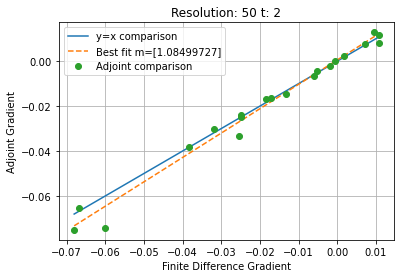

Starting forward run...
Starting adjoint run...
(-4.490074576370477e-06+1.0311530533854802e-05j)
Calculating gradient...


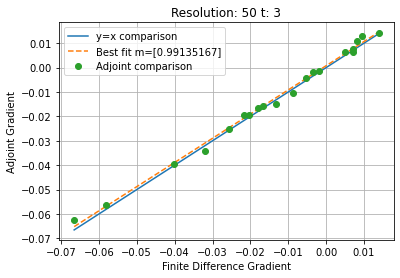

Starting forward run...
Starting adjoint run...
(-4.489661308045583e-06+1.0311136597143539e-05j)
Calculating gradient...


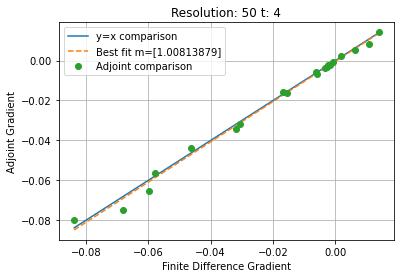

Starting forward run...
Starting adjoint run...
(-4.489431654142289e-06+1.031041797934587e-05j)
Calculating gradient...


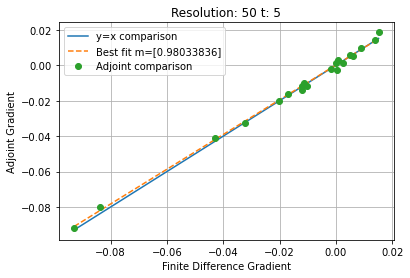

Starting forward run...
Starting adjoint run...
(-3.641264626461646e-06+7.87693164482714e-06j)
Calculating gradient...


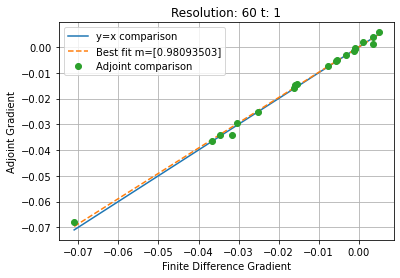

Starting forward run...
Starting adjoint run...
(-3.6411704269052724e-06+7.876603242092863e-06j)
Calculating gradient...


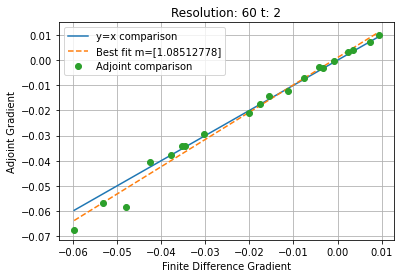

Starting forward run...
Starting adjoint run...
(-3.640984062507851e-06+7.876175463210288e-06j)
Calculating gradient...


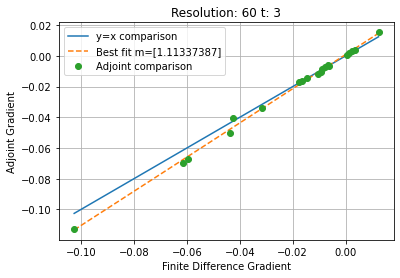

Starting forward run...
Starting adjoint run...
(-3.640834156681181e-06+7.87570599127683e-06j)
Calculating gradient...


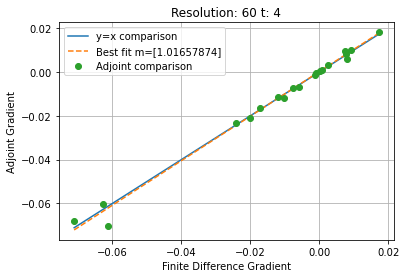

Starting forward run...
Starting adjoint run...
(-3.6407961170741172e-06+7.875412004180818e-06j)
Calculating gradient...


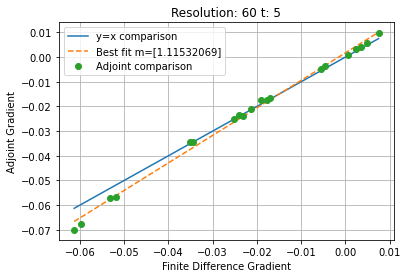

In [6]:
db = 1e-3
choose = 20
m_table = np.zeros((5,5))
b_table = np.zeros((5,5))
residue_table = np.zeros((5,5))
for resolution_idx in range(5):
    for t in range(5):
        resolution = (resolution_idx + 2)*10
        opt.sim.resolution = resolution
        f0, dJ_deps, dg = opt()
        g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
        g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)


        (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
        min_g = np.min(g_discrete)
        max_g = np.max(g_discrete)
        residue = np.sum((m * g_discrete + b - g_adjoint[idx])**2)
        
        m_table[t, resolution_idx] = m
        b_table[t, resolution_idx] = b
        residue_table[t, resolution_idx] = residue

        plt.figure()
        plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
        plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
        plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
        plt.xlabel('Finite Difference Gradient')
        plt.ylabel('Adjoint Gradient')
        plt.title('Resolution: {} t: {}'.format(resolution,t+1))
        plt.legend()
        plt.grid(True)
        plt.show()

In [7]:
b_table

array([[ 5.33359957e-04, -3.48972914e-04, -5.75849614e-04,
         2.99762778e-04, -8.99206845e-06],
       [-1.14678914e-03,  1.91521114e-04, -9.19615325e-04,
         5.34389053e-04,  1.01987261e-03],
       [-1.88544818e-03, -8.49482899e-04,  3.19620623e-04,
         7.68237979e-04,  8.68380022e-04],
       [-2.49762474e-03,  5.16412314e-04, -3.84968461e-04,
        -3.74497844e-04,  1.76138144e-04],
       [ 3.27886552e-05, -2.48876163e-03, -9.29961435e-04,
         1.33785117e-04,  1.71800290e-03]])

In [8]:
np.sum(b_table, axis=0)

array([-0.00496371, -0.00297928, -0.00249077,  0.00136168,  0.0037734 ])

In [9]:
residue_table

array([[6.49972017e-04, 3.64961025e-04, 1.94925886e-04, 1.50294787e-04,
        2.23188518e-05],
       [1.13068217e-03, 2.03059598e-04, 1.55039173e-04, 2.38608032e-04,
        1.22147934e-04],
       [1.11123674e-03, 3.55649556e-04, 6.93485124e-05, 4.93515142e-05,
        6.72793605e-05],
       [1.24244085e-04, 2.49402814e-04, 8.88007643e-05, 1.14497283e-04,
        1.06209447e-04],
       [1.75637151e-03, 1.05749687e-03, 1.64204334e-04, 5.02701426e-05,
        5.52128886e-05]])

In [10]:
np.sum(residue_table, axis=0)

array([0.00477251, 0.00223057, 0.00067232, 0.00060302, 0.00037317])

In [11]:
np.sum(m_table, axis=0)/5

array([1.10162785, 1.06001305, 1.0346179 , 1.02054531, 1.06226722])